In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


----------------------

# A sample Convolutional Neural Network

---------------------
---------------------
#### 1. Download the CIFAR10 dataset

    first we download the dataset needed, here we use the cifar10 image dataset

In [ ]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def device_stat(using_device):
    if using_device.type == 'cuda':
        print(torch.cuda.get_device_name(0))
        print('Memory Usage:')
        print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
        print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')
    else:
        print('cpu in use')

device_stat(device)

Tesla K80
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:375: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


In [ ]:
import torchvision
import torchvision.transforms as transforms

# when applied, this will normalize the data from the ranges of (-1) to 1 
train_transform = transforms.Compose([
    transforms.Resize((112,112)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

test_transform = transforms.Compose([
    transforms.Resize((112,112)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=train_transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=test_transform)

print('\ntraining data set number of sample images = ',len(trainset))
print('testing data set number of sample images  = ',len(testset))

Files already downloaded and verified
Files already downloaded and verified

training data set number of sample images =  50000
testing data set number of sample images  =  10000


---------------------
#### 2. Partition the Datset into batches

    here we partition the 50,000 training images into 100, making 500 batches and,
    10,000 sample images of test images into 100, making 100 batches
    
    where each batches contains 100 images

In [ ]:
batch_size = 250

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=2)

classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

device_stat(device)

Tesla K80
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:375: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


---------------------
##### (optionals) check the shape of our datasets

In [ ]:
# here we don't need to flatten every images in our dataset before feeding it to our neural network

for data in trainloader:
    images, labels = data
    print('images dataset shape = ', images.shape)
    print('labels dataset shape = ', labels.shape)
    break


images dataset shape =  torch.Size([250, 3, 112, 112])
labels dataset shape =  torch.Size([250])


---------------------
##### (optionals) Quick peek in the images

image shape =  torch.Size([3, 112, 112])


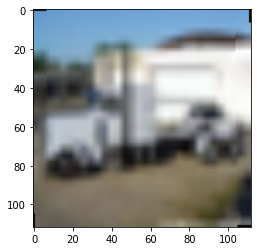

label :  truck
Tesla K80
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:375: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

for data in trainloader:
    image,label = data
    break

index = 0
image = image[index]

print('image shape = ',image.shape)

imshow(image)
print('label : ',classes[label[index].item()])

# x_proc = torch.unsqueeze(x_subject,0)
# print('unsqze x_proc shape', x_proc.shape)

# x_proc = net.conv1(x)

# print(x_proc.shape)
# print('label : ',classes[y[index]])

device_stat(device)

---------------------
#### 3. Build the Convolution Neural Network

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.maxPool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        # self.avePool = nn.AdaptiveAvgPool2d(output_size=(7, 7))

        self.drop1D = nn.Dropout(p=0.50, inplace=False)

        self.conv1 = nn.Conv2d(3, 16, 3, stride=1, padding=1)
        self.conv1_bn = nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
        self.conv2 = nn.Conv2d(16, 16, 3, stride=1, padding=1)
        self.conv2_bn = nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
        
        self.conv3 = nn.Conv2d(16, 32, 3, stride=1, padding=1)
        self.conv3_bn = nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
        self.conv4 = nn.Conv2d(32, 32, 3, stride=1, padding=1)
        self.conv4_bn = nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)

        self.conv5 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.conv5_bn = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        self.conv6 = nn.Conv2d(64, 64, 3, stride=1, padding=1)
        self.conv6_bn = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        
        self.conv7 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.conv7_bn = nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
        self.conv8 = nn.Conv2d(128, 128, 3, stride=1, padding=1)
        self.conv8_bn = nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)

        self.conv9 = nn.Conv2d(128, 256, 3, stride=1, padding=1)
        self.conv9_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
        self.conv10 = nn.Conv2d(256, 256, 3, stride=1, padding=1)
        self.conv10_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
        self.conv11 = nn.Conv2d(256, 256, 3, stride=1, padding=1)
        self.conv11_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)      

        self.fc1 = nn.Linear(2304, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        
        x = F.relu(self.conv1_bn(self.conv1(x)), inplace=True)
        x = F.relu(self.conv2_bn(self.conv2(x)), inplace=True)
        x = self.maxPool(x)
        # print('pool0 shape = ', x.shape)
         
        x = F.relu(self.conv3_bn(self.conv3(x)), inplace=True)
        x = F.relu(self.conv4_bn(self.conv4(x)), inplace=True)
        x = self.maxPool(x)
        # print('pool1 shape = ', x.shape)
        
        x = F.relu(self.conv5_bn(self.conv5(x)), inplace=True)
        x = F.relu(self.conv6_bn(self.conv6(x)), inplace=True)
        x = self.maxPool(x)
        # print('pool2 shape = ', x.shape)

        x = F.relu(self.conv7_bn(self.conv7(x)), inplace=True)
        x = F.relu(self.conv8_bn(self.conv8(x)), inplace=True)
        x = self.maxPool(x)
        # print('pool3 shape = ', x.shape)

        x = F.relu(self.conv9_bn(self.conv9(x)), inplace=True)
        x = F.relu(self.conv10_bn(self.conv10(x)), inplace=True)
        x = F.relu(self.conv11_bn(self.conv11(x)), inplace=True)
        x = self.maxPool(x)
        # print('pool4 shape = ', x.shape)

        # x = self.avePool(x)
        # print('poolAve shape = ', x.shape)

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.drop1D(x)
        # print('flatten shape = ', x.shape)
        
        x = F.relu(self.fc1(x), inplace=True)
        # print('first fc1 shape = ', x.shape)
        
        x = F.relu(self.fc2(x), inplace=True)
        # print('first fc2 shape = ', x.shape)

        x = self.fc3(x)
        # print('first fc3 shape = ', x.shape)

        # or use log_softmax
        # x = F.log_softmax(x, dim=1)
        # print('softmax shape = ', x.shape)

        return x


net = Net() # CPU

net.to(device) # GPU

print('device in use :',device)
print('available devices :',torch.cuda.device_count())
print(net)

device_stat(device)

device in use : cuda:0
available devices : 1
Net(
  (maxPool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1D): Dropout(p=0.5, inplace=False)
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:375: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


---------------------
#### (optionals) NOTE : if you are curious on how to get the shapes after pooling or convolution, this is the function

    though since I'm the one who wrote this one, there might be errors in this function

In [ ]:
def conv_out_len(N,kernel_len=1, stride=1):
    cnt = 0
    i = 0
    while i < N:
        if i+kernel_len > N:
            break
        cnt += 1
        i += stride
    return cnt

conv_out_len(6,kernel_len=2, stride=2)

3

---------------------
####  4. Choosing our optimizer
    
    you can use any optimizer you want, either the classic SGD(sochastic gradient descent), 
    or the newer ones like AdaGrad, and etc.
    
    but here we will used the most recent optimizer that is considered
    to be one of the fastest optimizer for updating our neural networks' weight called 'Adam',
    so that we will have a faster convergence and use only a small numbers of epoch(training loop)

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001)

device_stat(device)

Tesla K80
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:375: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


---------------------
#### 5. Train the neural network

In [ ]:
import time

start = time.time()


criterion1 = nn.CrossEntropyLoss()

EPOCH = 100

net.train()

i = 0
for epoch in range(EPOCH):
    i+=1
    print('(',round((i/EPOCH)*100,2),'%) Epoch : ',i,'/',EPOCH, sep='')
    for data in trainloader:
        # inputs, labels = data # CPU
        inputs, labels = data[0].to(device), data[1].to(device) # To GPU

        # print('currect epoch gpu input :')
        # device_stat(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        # loss = F.nll_loss(outputs, labels) # loss function use in tandem with log_softmax
        loss = criterion1(outputs, labels)
        loss.backward()
        optimizer.step()

end = time.time()

dur_sec = end-start
dur_min = dur_sec/60
dur_hr  = dur_min/60

print('Finished Training, \nTraining took',dur_sec,'seconds')
print('Min : ', dur_min)
print('Hr  : ', dur_hr)

(1.0%) Epoch : 1/100
(2.0%) Epoch : 2/100
(3.0%) Epoch : 3/100
(4.0%) Epoch : 4/100
(5.0%) Epoch : 5/100
(6.0%) Epoch : 6/100
(7.0%) Epoch : 7/100
(8.0%) Epoch : 8/100
(9.0%) Epoch : 9/100
(10.0%) Epoch : 10/100
(11.0%) Epoch : 11/100
(12.0%) Epoch : 12/100
(13.0%) Epoch : 13/100
(14.0%) Epoch : 14/100
(15.0%) Epoch : 15/100
(16.0%) Epoch : 16/100
(17.0%) Epoch : 17/100
(18.0%) Epoch : 18/100
(19.0%) Epoch : 19/100
(20.0%) Epoch : 20/100
(21.0%) Epoch : 21/100
(22.0%) Epoch : 22/100
(23.0%) Epoch : 23/100
(24.0%) Epoch : 24/100
(25.0%) Epoch : 25/100
(26.0%) Epoch : 26/100
(27.0%) Epoch : 27/100
(28.0%) Epoch : 28/100
(29.0%) Epoch : 29/100
(30.0%) Epoch : 30/100
(31.0%) Epoch : 31/100
(32.0%) Epoch : 32/100
(33.0%) Epoch : 33/100
(34.0%) Epoch : 34/100
(35.0%) Epoch : 35/100
(36.0%) Epoch : 36/100
(37.0%) Epoch : 37/100
(38.0%) Epoch : 38/100
(39.0%) Epoch : 39/100
(40.0%) Epoch : 40/100
(41.0%) Epoch : 41/100
(42.0%) Epoch : 42/100
(43.0%) Epoch : 43/100
(44.0%) Epoch : 44/100
(45.0%

---------------------
#### (optionals) Save the trained model

In [ ]:
net.eval()
net.to('cpu')
PATH = 'drive/MyDrive/Colab Notebooks/cifar10_cnn_bn_200epoch.pth'
torch.save(net.state_dict(), PATH)
net.to(device)

Net(
  (maxPool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1D): Dropout(p=0.5, inplace=False)
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): 

---------------------
#### (optionals)  Load the model back

In [ ]:
# net = Net()
# net.load_state_dict(torch.load(PATH))

---------------------
#### (optionals)  Try one item in the test dataset using the model

In [ ]:
# dataiter = iter(testloader)
# # images, labels = dataiter.next()

# # print images
# imshow(torchvision.utils.make_grid(images))
# print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

# outputs = net(images)
# _, predicted = torch.max(outputs, 1)

# print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]for j in range(4)))

---------------------
#### 6. Check the Accuracy of the model from out datasets

In [ ]:
start = time.time()

correct = 0
total = 0

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in trainloader:
        # images, labels = data
        images, labels = data[0].to(device), data[1].to(device) # To GPU
        # calculate outputs by running images through the network 
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on training images: %d %%' % (100 * correct / total))
        
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        # images, labels = data
        images, labels = data[0].to(device), data[1].to(device) # To GPU
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on testing images: %d %%' % (100 * correct / total))

end = time.time()

print('The whole cell took ',(end-start), 'seconds')

Accuracy of the network on training images: 98 %
Accuracy of the network on testing images: 89 %
The whole cell took  50.881430864334106 seconds
